<a href="https://colab.research.google.com/github/godspeedmc/About-myself/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import spacy

In [7]:
columns = ['id','country','Label','Text']
df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=columns)
print(df.shape)
df.head(5)

(74682, 4)


,id,country,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   country  74682 non-null  object
 2   Label    74682 non-null  object
 3   Text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
df['Label'].value_counts()

,count
Label,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


In [10]:
for i in range(5):
    print(f"{i+1}: {df['Text'][i]} -> {df['Label'][i]}")

1: im getting on borderlands and i will murder you all , -> Positive
2: I am coming to the borders and I will kill you all, -> Positive
3: im getting on borderlands and i will kill you all, -> Positive
4: im coming on borderlands and i will murder you all, -> Positive
5: im getting on borderlands 2 and i will murder you me all, -> Positive


In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound,df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   country  74682 non-null  object
 2   Label    74682 non-null  object
 3   Text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
df.isnull().sum()

,0
id,0
country,0
Label,0
Text,686


In [13]:
df.dropna(inplace=True)

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [16]:
df['Preprocessed Text'] = df['Text'].apply(preprocess)

In [17]:
df

,id,country,Label,Text,Preprocessed Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,m get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,m get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,m come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,m get borderland 2 murder
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realize Windows partition Mac like 6 year Nvid...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realize Mac window partition 6 year Nvidia dri...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realize window partition Mac 6 year Nvidia dri...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,realize window partition Mac like 6 year Nvidi...


In [18]:
le_model = LabelEncoder()
df['Label'] = le_model.fit_transform(df['Label'])

In [19]:
df.head(5)

,id,country,Label,Text,Preprocessed Text
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...,m get borderland murder
1,2401,Borderlands,3,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...,m get borderland kill
3,2401,Borderlands,3,im coming on borderlands and i will murder you...,m come borderland murder
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,m get borderland 2 murder


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['Preprocessed Text'], df['Label'],test_size=0.2, random_state=42, stratify=df['Label'])

In [21]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (59196,)
Shape of X_test:  (14800,)


In [22]:
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('naive_bayes', (MultinomialNB()))
])

In [23]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [25]:
y_pred = clf.predict(X_test)

In [26]:
print(accuracy_score(y_test, y_pred))

0.7322972972972973


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.46      0.62      2575
           1       0.65      0.90      0.76      4472
           2       0.84      0.64      0.72      3622
           3       0.71      0.81      0.76      4131

    accuracy                           0.73     14800
   macro avg       0.79      0.70      0.71     14800
weighted avg       0.77      0.73      0.72     14800



In [28]:
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('naive_bayes', (RandomForestClassifier()))
])

In [29]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', RandomForestClassifier())])

In [30]:
y_pred = clf.predict(X_test)

In [31]:
print(accuracy_score(y_test, y_pred))

0.9121621621621622


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2575
           1       0.92      0.93      0.93      4472
           2       0.94      0.89      0.91      3622
           3       0.85      0.95      0.90      4131

    accuracy                           0.91     14800
   macro avg       0.92      0.91      0.91     14800
weighted avg       0.92      0.91      0.91     14800



In [33]:
test_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names=columns)
test_df.head()

,id,country,Label,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [34]:
test_text = test_df['Text'][10]
print(f"{test_text} ===> {test_df['Label'][10]}")

The professional dota 2 scene is fucking exploding and I completely welcome it.

Get the garbage out. ===> Positive


In [35]:
test_text_processed = [preprocess(test_text)]
test_text_processed

['professional dota 2 scene fuck explode completely welcome \n\n garbage']

In [36]:
test_text = clf.predict(test_text_processed)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('random_forest', RandomForestClassifier())
])

In [38]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('random_forest', RandomForestClassifier())])

In [39]:
print(clf.named_steps['vectorizer_tri_grams'].vocabulary_)

{'toronto': 23712, 'canada': 4691, 'cultural': 6401, 'capital': 4745, 'surprise': 22651, 'want': 25332, 'start': 22180, 'plan': 18016, 'sure': 22635, 'check': 5125, 'autumn': 3022, '2020': 417, 'gta': 10837, 'real': 19265, 'estate': 8486, 'report': 19658, 'information': 12362, 'need': 16232, 'finally': 9216, 'warzone': 25391, 'actually': 1866, 'hella': 11379, 'super': 22584, 'fun': 9839, 'gg': 10260, 'band': 3297, 'callofduty': 4657, 'callofdutyuk': 4661, 'facebook': 8801, 'lose': 14459, 'boycott': 4208, 'battle': 3401, 'flip': 9385, 'it': 12706, 'p0tdfh': 17378, 'curse': 6441, 'show': 21227, 'pic': 17915, 'year': 26309, 'ago': 2055, 'red': 19377, 'backpack': 3213, 'friend': 9735, 'convince': 5973, 'climb': 5407, 'high': 11506, 'mountain': 15804, 'country': 6094, 'experience': 8684, 'life': 14152, 'traumatic': 23838, 'exhaust': 8653, 'jfc': 12986, 'twitter': 24150, 'com': 5639, 'wbunxhldy6': 25453, 'unpopular': 24560, 'list': 14255, 'opinion': 17073, 'apex': 2537, 'garbage': 10064, 'nd

In [40]:
test_text = test_df['Text'][10]
true_label = test_df['Label'][10]

print(f"Original Text: {test_text}")
print(f"True Label: {true_label}")

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(filtered_tokens)

test_text_processed = preprocess(test_text)

predicted_label_index = clf.predict([test_text_processed])[0]

classes = ['Irrelevant', 'Natural', 'Negative', 'Positive']

print(f"Predicted Label: {classes[predicted_label_index]}")

Original Text: The professional dota 2 scene is fucking exploding and I completely welcome it.

Get the garbage out.
True Label: Positive
Predicted Label: Positive


In [41]:
import re

def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower()
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(filtered_tokens)

In [42]:
from transformers import pipeline

paraphraser = pipeline("text2text-generation", model="t5-base")

def generate_paraphrase(text):
    input_text = f"paraphrase: {text}"
    paraphrase = paraphraser(input_text, max_length=50, num_return_sequences=1)
    return paraphrase[0]['generated_text']

original_sentence = "it's amazing!"
paraphrased_sentence = generate_paraphrase(original_sentence)
print(f"Original: {original_sentence}")
print(f"Paraphrased: {paraphrased_sentence}")

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Original: it's amazing!
Paraphrased: paraphrase: it's amazing!


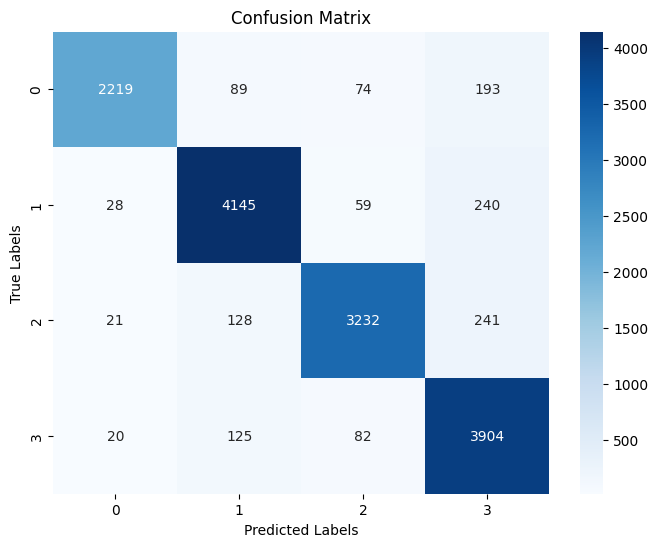

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2575
           1       0.92      0.93      0.93      4472
           2       0.94      0.89      0.91      3622
           3       0.85      0.95      0.90      4131

    accuracy                           0.91     14800
   macro avg       0.92      0.91      0.91     14800
weighted avg       0.92      0.91      0.91     14800



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [44]:
import joblib

joblib.dump(clf, 'text_classifier_model.pkl')

clf_loaded = joblib.load('text_classifier_model.pkl')

In [45]:
pip install transformers sentencepiece


In [46]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name = "ramsrigouthamg/t5_paraphraser"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def paraphrase(text, num_return_sequences=3, num_beams=5):
    input_text = f"paraphrase: {text} </s>"
    encoding = tokenizer.encode_plus(
        input_text,
        padding='max_length',
        return_tensors="pt",
        max_length=128,
        truncation=True
    )

    input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        temperature=1.5,
        top_k=120,
        top_p=0.95,
        early_stopping=True
    )

    final_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return final_outputs


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [47]:
input_sentence = "She enjoys reading books in the evening."
paraphrased_sentences = paraphrase(input_sentence)

for idx, sentence in enumerate(paraphrased_sentences):
    print(f"{idx+1}: {sentence}")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


1: She enjoys reading books in the evening.
2: She enjoys reading books in the evenings.
3: She loves reading books in the evening.


In [48]:
pip install sentence-transformers


In [49]:
from sentence_transformers import SentenceTransformer, util
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
def similarity_score(original, paraphrased_list):
    results = []
    original_embedding = similarity_model.encode(original, convert_to_tensor=True)

    for sent in paraphrased_list:
        paraphrased_embedding = similarity_model.encode(sent, convert_to_tensor=True)
        score = util.pytorch_cos_sim(original_embedding, paraphrased_embedding).item()
        results.append((sent, score))

    return sorted(results, key=lambda x: x[1], reverse=True)


In [50]:
sentence = "She enjoys reading books in the evening."
paraphrases = paraphrase(sentence)

similarities = similarity_score(sentence, paraphrases)

print(f"\nOriginal Sentence: {sentence}")
print("\nParaphrased Sentences with Similarity Scores:")
for sent, score in similarities:
    print(f"- {sent} (Score: {score:.2f})")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Original Sentence: She enjoys reading books in the evening.

Paraphrased Sentences with Similarity Scores:
- She enjoys reading books in the evening. (Score: 1.00)
- She enjoys reading books in the evenings. (Score: 0.96)
- She loves reading books in the evening. (Score: 0.94)
